# Introduction
We will create a class of support vector machine (SVM, support vector machine) for classification by scratch. We will implement the algorithm using only the minimum library such as NumPy.


There are soft margin SVMs that allow classification errors during learning and hard margin SVMs that do not, but here we will deal with hard margin SVMs that are simple to implement.



In [1]:
#predefines and imports
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Prototype

In [68]:
class ScratchSVMClassifier():
    """
    Scratch implementation of SVM classifier
    Parameters
    ----------
    num_iter : int
      Number of iterations
    lr : float
      Learning rate
    kernel : str
      Kernel type. Linear kernel (linear) or polynomial kernel (polly)
    threshold : float
      Threshold for choosing a support vector
    verbose : bool
      True to output the learning process
    Attributes
    ----------
    self.n_support_vectors : int
      Number of support vectors
    self.index_support_vectors : The following form of ndarray, shape (n_support_vectors,)
      Support vector index
    self.X_sv :  The following forms of ndarray, shape (n_support_vectors, n_features)
      Support vector features
    self.lam_sv :  The following forms of ndarray, shape (n_support_vectors, 1)
      Support vector undetermined multiplier
    self.y_sv :  The following forms of ndarray, shape (n_support_vectors, 1)
      Support vector label
    """
    def __init__(self, num_iter, lr, kernel='linear', threshold=1e-5, verbose=False, debug = False):
        # Record hyperparameters as attributes
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
        self.debug = debug
    def kernel_function(self,Xi,Xj):
      if self.kernel == 'linear':
        return Xi @ Xj.T
      if self.kernel == 'poli':
        return None
    def fit(self, X, y, X_val=None, y_val=None):

        #Prep part
        np.random.seed(2000)
        self.lagrange_multiplier = np.random.rand(X.shape[0], 1) #this can be dim 1 or 0
        y = y.reshape(-1,1)
        y_val = y_val.reshape(-1,1) if y_val else None

        if self.verbose:
          print('Xshape: ', X.shape, 'yshape: ', y.shape)
          if X_val:
            print('XValshape: ', X_val.shape, 'yvalshape: ', y_val.shape)
        
        #Learn part
        if self.debug:
          print('Origin lagrange_multiplier: ')
          print(self.lagrange_multiplier)
        for i in range(self.iter):
          # print('Before: ', self.lagrange_multiplier)
          self.lagrange_multiplier = self.update_lagrange(X,y)
          # print('After: ', self.lagrange_multiplier)     
          # Validation part
          self.validate(X_val,y_val)    
        
        #get sv part
        sv_index = []
        for idx, l in enumerate(self.lagrange_multiplier):
          if l > self.threshold: sv_index.append(idx)
        self.support_vectors_ = X[sv_index]
        self.n_support_vectors = len(sv_index)
        self.sv_lagrange = self.lagrange_multiplier[sv_index]
        self.sv_labels = y[sv_index]


        # verbose part
        if self.verbose:
            result = pd.DataFrame({
              # 'SV Index': np.array(sv_index).reshape(-1,1),
              'support_vectors':[str(x) for x in self.support_vectors_],
              'label': self.sv_labels.ravel(),
            }, index = sv_index)
            print('Number of SVs: ', self.n_support_vectors)
            print(result)
            print('Training Score: ', None)
            print('Validation Score: ', None)
            if self.debug: print('LagrangeMultiplier: ', self.lagrange_multiplier)
    def validate(self,X_val,y_val): pass
    def update_lagrange(self,X,y):
      lm = self.lagrange_multiplier
      for i in range(lm.shape[0]): #! update each lagrange multiple for each X_sample
        temp = 0
        #calc sum
        for j in range(lm.shape[0]):
          # if i == j: continue
          temp += lm[j] * y[j] * self.kernel_function(X[i],X[j])
        gradient_i = 1 - y[i] * temp
        #update
        lm[i] = max(0,lm[i] + self.lr * gradient_i)
      if self.debug:
        print('new lagrange_multiplier: ')
        print(lm)
      return lm 

    def predict(self, X):
        
        #prep
        result = np.zeros((X.shape[0],1))

        #predict 
        for i in range(X.shape[0]):
          result[i] = self.predict_x(X[i])
        return result
    def predict_x(self,x):
      fx = 0
      for i in range(self.n_support_vectors):
        fx += self.sv_lagrange[i] * self.sv_labels[i] * self.kernel_function(x, self.support_vectors_[i])
      sign = lambda x:  1 if x > 0 else -1
      return sign(fx)

# My Test

In [69]:
# ! simple test!

from sklearn.svm import SVC
ssvm = ScratchSVMClassifier(1000,0.1,verbose = True,debug = False)
x = np.array([[1,1],
    [2,1],
    [1,2],
    [2,2]])
y = np.array([-1,-1,1,1])
ssvm.fit(x,y)
print('Prediction: ',ssvm.predict(x))


print('----------------------')
svc = SVC(kernel = 'linear', max_iter = 1000, verbose = True, tol = 1e-5)
svc.fit(x,y)
svc.predict(x)
print('SV: ')
print (svc.support_vectors_)
print('Lambda: ')
print(np.abs(svc.dual_coef_))

Xshape:  (4, 2) yshape:  (4, 1)
Number of SVs:  3
  support_vectors  label
0           [1 1]     -1
1           [2 1]     -1
3           [2 2]      1
Training Score:  None
Validation Score:  None
Prediction:  [[ 1.]
 [-1.]
 [ 1.]
 [ 1.]]
----------------------
[LibSVM]SV: 
[[1. 1.]
 [2. 1.]
 [1. 2.]
 [2. 2.]]
Lambda: 
[[1. 1. 1. 1.]]


# Problem 1,2,3
Gradient, SV determination, Estimation, Validation

In [70]:
# Simple dataset:
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, n_samples // 2)
f1 = np.random.multivariate_normal(f1, cov, n_samples // 2)
X = np.concatenate([f0, f1])
y = np.concatenate([
    np.full(n_samples // 2, 1),
    np.full(n_samples // 2, -1)
])


# test

print('My result: ')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
x_train,x_test,y_train,y_test = train_test_split(X,y, test_size = 0.2)
model = ScratchSVMClassifier(100,0.01,verbose = True)
model.fit(x_train,y_train)
pred = model.predict(x_test)
print(confusion_matrix(pred,y_test))


print('Sklearn Result:')
svc.fit(x_train,y_train)
pred = svc.predict(x_test)
print(confusion_matrix(pred, y_test))
print('SV: ')
print (svc.support_vectors_)
print('Lambda: ')
print(np.abs(svc.dual_coef_))

Xshape:  (400, 2) yshape:  (400, 1)
Number of SVs:  11
               support_vectors  label
17   [ 0.95883548 -0.42178667]     -1
90   [-0.03216445  1.71398505]      1
105  [-0.34408497  1.31133472]      1
182    [0.87647173 2.56307107]      1
186  [-0.6439502   1.05722492]      1
236    [1.95685959 0.21221127]     -1
282    [1.71392653 0.10694699]     -1
307  [-0.55980595  1.00527315]      1
355  [-0.68857552 -2.3249237 ]     -1
389    [2.47677571 0.86057603]     -1
392  [-0.60267959  1.39367004]      1
Training Score:  None
Validation Score:  None
[[52  0]
 [ 0 48]]
[LibSVM][[52  0]
 [ 0 48]]


# Problem 5
Visualize Hyperplane

In [71]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    # settings
    scatter_color = ['red', 'blue']
    contourf_color =  ['pink', 'skyblue']
    n_class = 2

    # prepare meshgrid
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]

    # predict
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    #plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)

    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    #!plot svs
    plt.scatter(model.support_vectors_[:,0], model.support_vectors_[:,1],color = 'yellow',s=80, label = 'SV')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

My model: 


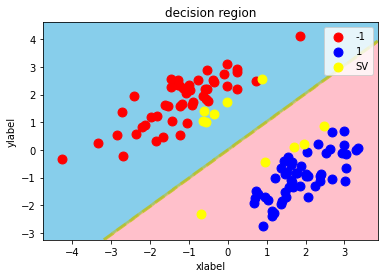

Sklearn: 


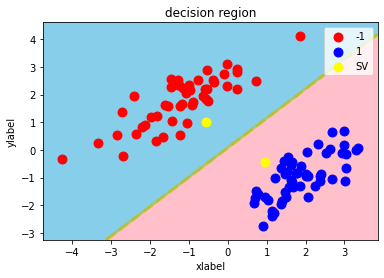

In [72]:
print('My model: ')
decision_region(x_test,y_test,model,target_names = ['-1', '1'])
print('Sklearn: ')
decision_region(x_test,y_test,svc, target_names = ['-1', '1'])

array([[1, 1],
       [2, 1],
       [2, 2]])